## tf.estimator, tf.feature_column, keras_to_estimator

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
matplotlib 2.0.2
numpy 1.17.0
pandas 0.24.2
sklearn 0.22.2.post1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
# 读取数据
train_file = '/Volumes/TOSHIBA/titanic/train_new.csv'
eval_file = '/Volumes/TOSHIBA/titanic/eval_new.csv'

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [4]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [6]:
# 查看统计量
print(train_df.shape,eval_df.shape)

(627, 9) (264, 9)


In [7]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


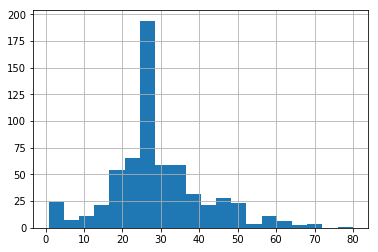

In [10]:
# 查看年龄分布，直方图
train_df.age.hist(bins=20)

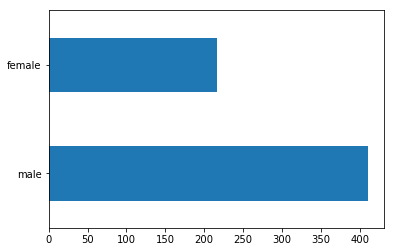

In [11]:
# 查看性别分布
train_df.sex.value_counts().plot(kind = 'barh') 

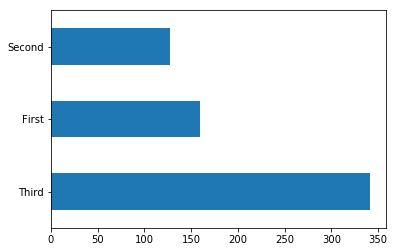

In [12]:
# 查看类别分布
train_df['class'].value_counts().plot(kind = 'barh')

In [14]:
# 离散特征
categorical_colums = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
numerical_columns = ['age','fare']

feature_columns = []
# 离散
for categorical_column in categorical_colums:
    vocab = train_df[categorical_column].unique() # 获取所有可能的值, list
    print(categorical_column,vocab)
    # one-hot 编码，
    feature_columns.append(
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(categorical_column,vocab)))

# 连续
for categorical_column in numerical_columns:
    feature_columns.append(tf.feature_column.numeric_column(categorical_column,dtype=tf.float32))


sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [20]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town',

In [15]:
# 构建dataset
def make_dataset(data_df,label_df,epochs=10,shuffle=True,batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [16]:
train_dataset = make_dataset(train_df,y_train,batch_size = 5)

In [19]:
for x,y in train_dataset.take(1):
    print(x,y)

{'sex': <tf.Tensor: id=72, shape=(5,), dtype=string, numpy=array([b'male', b'female', b'male', b'female', b'male'], dtype=object)>, 'age': <tf.Tensor: id=64, shape=(5,), dtype=float64, numpy=array([36., 30., 33., 28., 49.])>, 'n_siblings_spouses': <tf.Tensor: id=70, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 1], dtype=int32)>, 'parch': <tf.Tensor: id=71, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 2, 0], dtype=int32)>, 'fare': <tf.Tensor: id=69, shape=(5,), dtype=float64, numpy=array([40.125 ,  8.6625,  9.5   , 15.2458, 56.9292])>, 'class': <tf.Tensor: id=66, shape=(5,), dtype=string, numpy=array([b'First', b'Third', b'Third', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: id=67, shape=(5,), dtype=string, numpy=array([b'A', b'unknown', b'unknown', b'unknown', b'A'], dtype=object)>, 'embark_town': <tf.Tensor: id=68, shape=(5,), dtype=string, numpy=
array([b'Cherbourg', b'Southampton', b'Southampton', b'Cherbourg',
       b'Cherbourg'], dtype=object)>, 'alone': <tf.Te

In [21]:
# feature_column 与dataset 结合使用
# keras.layers.DenFeature
for x,y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())

W0516 10:47:40.884976 140737132438464 base_layer.py:1814] Layer dense_features is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0516 10:47:41.009108 140737132438464 base_layer.py:1814] Layer dense_features_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dt

[[28. ]
 [40.5]
 [25. ]
 [28. ]
 [28. ]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [22]:
# feature_column 与dataset 结合使用
# keras.layers.DenFeature
for x,y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())

W0516 10:49:40.915173 140737132438464 base_layer.py:1814] Layer dense_features_2 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[[31.      1.      0.      0.      0.      1.      1.      0.      0.
   0.      0.      0.      0.      0.      0.      1.      0.      0.
  37.0042  1.      0.      0.      0.      0.      0.      0.      0.
   1.      0.      0.      0.      0.      1.      0.    ]
 [20.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   9.225   0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.      0.    ]
 [27.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   7.8958  0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.      0.    ]
 [34.      1.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
  14.4     1.      0.      0.      0.      0.      0.

In [23]:
# 构建keras模型
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(2,activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [25]:
# 1. model.fit
# 2. model -> estimator -> trian

train_dataset = make_dataset(train_df,y_train,epochs=100)   # 默认 batch_size = 32
eval_dataset = make_dataset(eval_df,y_eval,epochs=1,shuffle=False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch=20,
                    validation_steps=8,
                    epochs=50)

Train for 20 steps, validate for 8 steps
Epoch 1/50
20/20 [==============================] - 0s 12ms/step - loss: 0.5242 - accuracy: 0.7703 - val_loss: 0.4956 - val_accuracy: 0.7383
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.4898 - accuracy: 0.7688 - val_loss: 0.5003 - val_accuracy: 0.7344
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.4914 - accuracy: 0.7828 - val_loss: 0.5500 - val_accuracy: 0.7305
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.5078 - accuracy: 0.7469 - val_loss: 0.5244 - val_accuracy: 0.7148
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5105 - accuracy: 0.7516 - val_loss: 0.4919 - val_accuracy: 0.7500
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.5217 - accuracy: 0.7391 - val_loss: 0.4898 - val_accuracy: 0.7578
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 0.5638 - accuracy: 0.7063 - val_loss: 0.4924 -

In [28]:
# # 保存输出模型
# output_dir = 'baseline_model'
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)

# baseline_estimator = tf.estimator.BaselineClassifier(model_dir = output_dir,n_classes=2)
# baseline_estimator.train(input_fn = lambda:make_dataset(train_df,y_train,epochs=100))

# baseline_estimator.evaluate(input_fn = lambda : make_dataset(eval_df,y_eval,epochs=1,shuffle=False,batch_size=20))